In [1]:
import pysam
import os
import sys
from sys import getsizeof
import time

directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, add_read_information_to_barcode_dict, get_hamming_distance


# An example on a bam for 875 cell barcodes (group0, group1, group2, group3, group4, group5, group6 split from the original bam)

### Should be about 875*30,000 = 26 million reads

#### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
bampath = '/projects/ps-yeolab3/ekofman/sailor2/data/groups_0_1_2_3_4_5_6_merged.bam'


In [35]:
samfile = pysam.AlignmentFile(bampath, "rb")



# Full test

In [116]:
from collections import defaultdict
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
#%load_ext memory_profiler


output_folder = '/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs'

MAX_NUM_READS = 1000000

# TOLERANCES/THRESHOLD FOR FILTERING
edit_type_of_interest = 'C>T'

dist_from_end_tolerance = 5
base_quality_threshold = 37
mapping_quality_threshold = 255

# DICTIONARIES TO FILL WITH EDIT INFORMATION
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict())))) 


contig_lengths_dict = get_contig_lengths_dict(samfile)

# THE HEAVY LIFTING
counts = defaultdict(lambda:defaultdict(lambda:0))
coverage_dict = {}
num_edits_per_read = {}
mapping_quality_per_read = {}

# Print info?
verbose = False 


    
EDITED_CODE = 'edited'
deletions = []

contigs = []


import time
start_time = time.perf_counter()


num_reads_to_coverage_dict_kb = {}
num_reads_to_seconds = {}






barcodes = defaultdict(lambda:defaultdict(lambda:[]))

total_reads = 0
for contig in contig_lengths_dict.keys():
    print(contig)
    try:
        contig_length = contig_lengths_dict.get(contig)
        reads_for_contig = samfile.fetch(contig, 0, contig_length)

        edit_info_subfolder = '{}/edit_info'.format(output_folder)
        if not os.path.exists(edit_info_subfolder):
            os.mkdir(edit_info_subfolder)
            
        output_file = '{}/{}_edit_info.tsv'.format(edit_info_subfolder, contig)
        if os.path.exists(output_file):
            print("{} exists... deleting".format(output_file))
            os.remove(output_file)
            
            
        with open(output_file, 'w') as f:
                                    
            f.write('barcode\tcontig\tposition\tref\talt\tread_id\tstrand\tdist_from_end\tbase_quality\n')                       
            for i, read in enumerate(reads_for_contig):
                total_reads += 1
                if total_reads % 100000 == 0:
                    print("\tTotal reads: {}".format(total_reads))

                barcodes[contig][read.get_tag("CB")].append(read)
                #reference_positions_covered_by_read = update_coverage_array(read, contig, contig_length, barcode_to_coverage_dict)

                error_code, list_of_rows, num_edits_of_each_type = add_read_information_to_barcode_dict(read, contig, verbose=verbose)

                if error_code:
                    counts[contig][error_code] += 1
                else:
                    counts[contig][EDITED_CODE] += 1
                    for info_list in list_of_rows:
                        info_line = '\t'.join(info_list) + '\n'
                        f.write(info_line)
                        
                # BREAK OUT EARLY ONCE WE HIT NUMBER OF READS
                if counts[contig][error_code] + counts[contig][EDITED_CODE]> MAX_NUM_READS:
                    print("We maxed out past {}".format(MAX_NUM_READS))
                    break
                
        
        contigs.append(contig)
        
        num_reads_to_coverage_dict_kb[total_reads] = getsizeof(coverage_dict)/1000
        num_reads_to_seconds[total_reads] = time.perf_counter() - start_time
        
    
    except Exception as e:
        print(contig, e)
        
    

1
	Total reads: 100000
	Total reads: 200000
	Total reads: 300000
10
	Total reads: 400000
	Total reads: 500000
	Total reads: 600000
11
	Total reads: 700000
	Total reads: 800000
	Total reads: 900000
	Total reads: 1000000
	Total reads: 1100000
12
	Total reads: 1200000
	Total reads: 1300000
13
	Total reads: 1400000
	Total reads: 1500000
14
	Total reads: 1600000
	Total reads: 1700000
	Total reads: 1800000
15
	Total reads: 1900000
	Total reads: 2000000
16
	Total reads: 2100000
	Total reads: 2200000
	Total reads: 2300000
17
	Total reads: 2400000
	Total reads: 2500000
	Total reads: 2600000
	Total reads: 2700000
	Total reads: 2800000
18
	Total reads: 2900000
19
	Total reads: 3000000
	Total reads: 3100000
	Total reads: 3200000
	Total reads: 3300000
2
	Total reads: 3400000
	Total reads: 3500000
	Total reads: 3600000
	Total reads: 3700000
	Total reads: 3800000
3
	Total reads: 3900000
	Total reads: 4000000
	Total reads: 4100000
4
	Total reads: 4200000
	Total reads: 4300000
	Total reads: 4400000
5
	

In [ ]:
barcodes.get('1')

In [122]:
import shutil

num_barcodes = 0
for contig, reads_for_barcode_in_contig in barcodes.items():
    for barcode, reads_for_barcode in reads_for_barcode_in_contig.items():
        num_barcodes += 1
        if num_barcodes % 100 == 0:
            print("Barcode {} (#{})".format(barcode, num_barcodes))
        barcode_bam_file_name = "{}.bam".format(barcode)

        bam_for_barcode = pysam.AlignmentFile(barcode_bam_file_name, "wb", template=samfile)
        for read in reads_for_barcode:
            bam_for_barcode.write(read)
        bam_for_barcode.close()
        
        split_bams_subfolder = '{}/split_bams/'.format(output_folder)
        if not os.path.exists(split_bams_subfolder):
            os.mkdir(split_bams_subfolder)
            
        folder_name = '{}/contig_{}'.format(split_bams_subfolder, contig)
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        
        new_bam_location = '{}/{}'.format(folder_name, barcode_bam_file_name)
        shutil.move(barcode_bam_file_name, new_bam_location)
        
        if not os.path.exists('{}.bai'.format(new_bam_location)):
            print('indexing')
            pysam.index(new_bam_location)


indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
Barcode AAAGAACTCTCACCCA-1 (#100)
indexing
indexing
indexing
indexing
indexing
indexing
indexing
indexing
ind

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ekofman/new_anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-122-91f8f94b65bc>", line 11, in <module>
    bam_for_barcode = pysam.AlignmentFile(barcode_bam_file_name, "wb", template=samfile)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekofman/new_anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekofman/new_anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of

TypeError: object of type 'NoneType' has no len()

# Second loop to get coverage at sites with edits

In [156]:
all_edit_info_for_barcodes = []

for contig in contig_lengths_dict.keys():
    print(contig)
    reads_skipped = 0
    
    barcode_to_coverage_dict = defaultdict()
    
    
    contig_length = contig_lengths_dict.get(contig)
    
    barcode_to_coverage_dict = defaultdict()
    output_file = '{}/edit_info/{}_edit_info.tsv'.format(output_folder, contig)
    edit_info = pd.read_csv(output_file, sep='\t')
    
    unique_barcodes = sorted(edit_info.barcode.unique())
    

    for barcode in unique_barcodes:
        if barcode != 'AAACCCAAGATTGCGG-1':
            continue
            
        print(barcode)
    
        barcode_bam = '{}/split_bams/contig_{}/{}.bam'.format(output_folder, contig, barcode)
    
        try:
            samfile_for_barcode = pysam.AlignmentFile(barcode_bam, "rb")

            edit_info_for_barcode = edit_info[edit_info.barcode == barcode]
            positions_for_barcode = edit_info_for_barcode.position.tolist()

            coverage = []
            for pos in positions_for_barcode:
                coverage_at_pos = np.sum(samfile_for_barcode.count_coverage(contig, pos-1, pos))
                coverage.append(coverage_at_pos)

            edit_info_for_barcode['coverage'] = coverage
            all_edit_info_for_barcodes.append(edit_info_for_barcode)
        except Exception as e:
            print(e)


    


1
AAACCCAAGATTGCGG-1
10


/home/ekofman/new_anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AAACCCAAGATTGCGG-1
11
AAACCCAAGATTGCGG-1
12
AAACCCAAGATTGCGG-1
13
AAACCCAAGATTGCGG-1
14
AAACCCAAGATTGCGG-1
15
AAACCCAAGATTGCGG-1
16
AAACCCAAGATTGCGG-1
17
AAACCCAAGATTGCGG-1
18
AAACCCAAGATTGCGG-1
19
AAACCCAAGATTGCGG-1
2
AAACCCAAGATTGCGG-1
3
AAACCCAAGATTGCGG-1
4
AAACCCAAGATTGCGG-1
5
AAACCCAAGATTGCGG-1
6
AAACCCAAGATTGCGG-1
7
AAACCCAAGATTGCGG-1
8
AAACCCAAGATTGCGG-1
9
AAACCCAAGATTGCGG-1
MT
AAACCCAAGATTGCGG-1
X
AAACCCAAGATTGCGG-1
Y
AAACCCAAGATTGCGG-1
JH584299.1
GL456233.1
JH584301.1
GL456211.1
GL456350.1
JH584293.1
GL456221.1
JH584297.1
JH584296.1
GL456354.1
JH584294.1
JH584298.1
JH584300.1
GL456219.1
GL456210.1
JH584303.1
JH584302.1
GL456212.1
JH584304.1
AAACCCAAGATTGCGG-1
[Errno 2] could not open alignment file `/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs/split_bams/contig_JH584304.1/AAACCCAAGATTGCGG-1.bam`: No such file or directory
GL456379.1
GL456216.1
AAACCCAAGATTGCGG-1
[Errno 2] could not open alignment file `/projects/ps-yeolab3/ekofman/sailor2/sc

In [157]:
len(all_edit_info_for_barcodes)

22

In [159]:
all_edit_info = pd.concat(all_edit_info_for_barcodes)

In [187]:
all_edit_info['contig'] = all_edit_info.contig.astype(str)

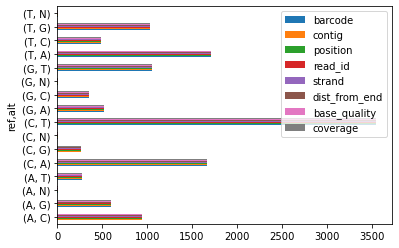

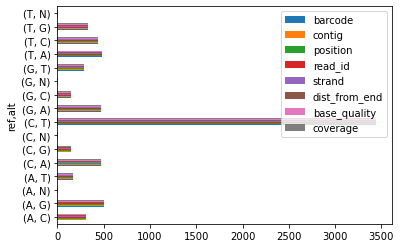

In [188]:
all_edit_info.groupby(['ref', 'alt']).count().plot(kind='barh')

all_edit_info[all_edit_info.base_quality > 13].groupby(['ref', 'alt']).count().plot(kind='barh')


all_edit_info_filtered = all_edit_info[all_edit_info.base_quality > 13]

In [189]:
example_new_ct =  all_edit_info_filtered[(all_edit_info_filtered.ref == 'C') & (all_edit_info_filtered.alt == 'T')].sort_values('position')

In [190]:
len(example_new_ct)

3446

In [191]:
example_new_ct

,barcode,contig,position,ref,alt,read_id,strand,dist_from_end,base_quality,coverage
1587,AAACCCAAGATTGCGG-1,MT,3581,C,T,A01535:287:H3JJHDSX7:1:2676:12671:11694,+,29,37,32
2002,AAACCCAAGATTGCGG-1,MT,4070,C,T,A01535:287:H3JJHDSX7:1:1109:10936:17394,+,2,37,2
6595,AAACCCAAGATTGCGG-1,MT,6667,C,T,A01535:287:H3JJHDSX7:1:1111:11586:9095,+,25,37,59
7837,AAACCCAAGATTGCGG-1,MT,6733,C,T,A01535:287:H3JJHDSX7:1:1310:3531:28150,+,33,37,136
9223,AAACCCAAGATTGCGG-1,MT,6783,C,T,A01535:287:H3JJHDSX7:1:1140:5204:36558,+,16,37,142
...,...,...,...,...,...,...,...,...,...,...
89687,AAACCCAAGATTGCGG-1,1,182132305,C,T,A01535:287:H3JJHDSX7:1:1655:15600:27571,+,35,37,2
90157,AAACCCAAGATTGCGG-1,1,182882571,C,T,A01535:287:H3JJHDSX7:1:1249:5077:30765,+,4,37,2
90580,AAACCCAAGATTGCGG-1,1,183334216,C,T,A01535:287:H3JJHDSX7:1:1107:26250:2487,-,27,37,1
91178,AAACCCAAGATTGCGG-1,1,185357519,C,T,A01535:287:H3JJHDSX7:1:1428:10809:23469,+,47,37,1


# Cells that do have STAMP expressed versus don't...?

In [192]:
example_dataframe_filtered

NameError: name 'example_dataframe_filtered' is not defined

# Extract only reads for a barcode

In [193]:
# Get edits for barcode
barcode = 'AAACCCAAGATTGCGG'


example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])


In [198]:

comparison_vals = []
overlapping_by_contig = {}
old_for_contig = {}
new_for_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    old_for_contig[contig] = example_old_ct_for_contig
    new_for_contig[contig] = example_new_ct_for_contig
    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


contig 1
	Number of sites in old version: 11
	Number of sites recapitulated: 11
contig 10
	Number of sites in old version: 15
	Number of sites recapitulated: 13
contig 11
	Number of sites in old version: 32
	Number of sites recapitulated: 29
contig 12
	Number of sites in old version: 21
	Number of sites recapitulated: 19
contig 13
	Number of sites in old version: 3
	Number of sites recapitulated: 2
contig 14
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 15
	Number of sites in old version: 19
	Number of sites recapitulated: 17
contig 16
	Number of sites in old version: 5
	Number of sites recapitulated: 5
contig 17
	Number of sites in old version: 17
	Number of sites recapitulated: 15
contig 18
	Number of sites in old version: 1
	Number of sites recapitulated: 1
contig 19
	Number of sites in old version: 23
	Number of sites recapitulated: 22
contig 2
	Number of sites in old version: 20
	Number of sites recapitulated: 20
contig 3
	Number of sites in old ver

# Which sites are we recovering?

In [201]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

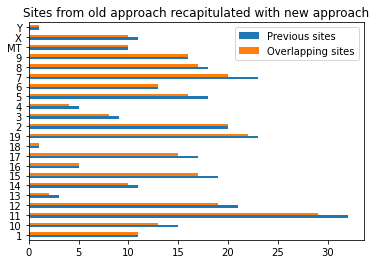

In [202]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].head(22).plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [203]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: 1.0
10
	Correlation between old coverage and new coverage values: 1.0
11
	Correlation between old coverage and new coverage values: 1.0
12
	Correlation between old coverage and new coverage values: 1.0
13
	Correlation between old coverage and new coverage values: 1.0
14
	Correlation between old coverage and new coverage values: 1.0
15
	Correlation between old coverage and new coverage values: 1.0
16
	Correlation between old coverage and new coverage values: 1.0
17
	Correlation between old coverage and new coverage values: 1.0
18
	Correlation between old coverage and new coverage values: nan
19
	Correlation between old coverage and new coverage values: 1.0
2
	Correlation between old coverage and new coverage values: 1.0
3
	Correlation between old coverage and new coverage values: 1.0
4
	Correlation between old coverage and new coverage values: 1.0
5
	Correlation between old coverage and new coverage values: 1.0
6
	Correlation 